In [ ]:
!pip install awswrangler mlflow

# 0.0. Requirements

## 0.1. Imports

In [62]:
import numpy as np
import pandas as pd
import awswrangler as wr

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)

## 0.2. Aux Functions

## 0.3. Read Data

In [ ]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM abt_seller_churn",
    database="grc_iceberg_analytics"
)

Some of the records from 2018-09-01 and 2018-10-01 do not exists on real dataset (orders and order_items).

I will consider the last month (2018-09-01) for new sellers scoring, such as production.

And i will use 2018-01-01 and 2018-07-01 as a train and test and 2018-08-01 as a oot base.

In [3]:
df[["seller_id", "_mt_date_reference", "churn"]].groupby(["_mt_date_reference", "churn"]).count().reset_index()

,_mt_date_reference,churn,seller_id
0,2018-01-01,0,687
1,2018-01-01,1,381
2,2018-02-01,0,733
3,2018-02-01,1,314
4,2018-03-01,0,764
5,2018-03-01,1,356
6,2018-04-01,0,795
7,2018-04-01,1,326
8,2018-05-01,0,850
9,2018-05-01,1,406


In [4]:
df = df[df["_mt_date_reference"] <= "2018-08-01"].reset_index(drop=True)
df_raw = df[df["_mt_date_reference"] < "2018-08-01"].reset_index(drop=True)
df_oot = df[df["_mt_date_reference"] >= "2018-08-01"].reset_index(drop=True)

In [5]:
id_cols = ["_mt_date_reference", "seller_id"]
target_col = ["churn"]

df_raw.drop(columns=id_cols, inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw[df_raw.columns.drop(target_col)],
    df_raw[target_col],
    random_state=2,
    train_size=0.8
)

In [7]:
print(y_train.mean())
print(y_test.mean())
print(df_oot[target_col].mean())

churn    0.323018
dtype: float64
churn    0.323583
dtype: float64
churn    0.339373
dtype: float64


In [8]:
X_train["churn"] = y_train
X_test["churn"] = y_test

In [19]:
df_oot[target_col[0]].value_counts()

churn
0    948
1    487
Name: count, dtype: int64

# 1.0. Descriptive Statistics

In [20]:
df1 = X_train.copy()
mask = df1["churn"] == 1

## 1.1. Data Dimension

In [21]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

Number of Rows: 6560
Number of Cols: 29


## 1.2. Check Missing Values

In [22]:
df1.isna().sum() / len(df1)

recency                           0.000000
avg_ticket                        0.000000
avg_order_product                 0.000000
max_order_items_price             0.000000
min_order_items_price             0.000000
avg_order_items_price             0.000000
max_item_price                    0.000000
min_item_price                    0.000000
avg_item_price                    0.000000
quantity_date_orders              0.000000
quantity_products_selled          0.000000
quantity_unique_product_selled    0.000000
avg_seller_interval               0.107774
ltv                               0.000000
days_from_first_sell              0.000000
frequency                         0.097104
avg_freight_value                 0.000000
min_freight_value                 0.000000
max_freight_value                 0.000000
avg_approval_delivery_days        0.000000
min_approval_delivery_days        0.000000
max_approval_delivery_days        0.000000
avg_approval_purchase_days        0.000000
min_approva

## 1.3. Fillout Missing Values

In [23]:
fill_zero = [
    "avg_seller_interval",
    "frequency",
    "pct_delay_delivered_orders"
]

for k in fill_zero:
    df1[k].fillna(0, inplace=True)

## 1.4. Descriptive Statistics

In [45]:
dfm = pd.DataFrame([
    df1.apply(lambda x: x.skew()),
    df1.apply(lambda x: ((x.quantile(.75) - x.quantile(.5)) - (x.quantile(.5) - x.quantile(.25))) / 1 + (x.quantile(.75) - x.quantile(.25))),
    df1.apply(lambda x: x.kurtosis())
]).T

dfm.columns = ["skew", "bowley", "kurtosis"]

In [52]:
pd.concat([df1.describe().T, dfm], axis=1).iloc[:, 1:]

,mean,std,min,25%,50%,75%,max,skew,bowley,kurtosis
recency,13.615549,12.014148,1.000000,4.000000,10.000000,21.000000,45.000000,0.928967,22.000000,-0.167434
avg_ticket,159.346934,218.631887,3.746667,56.857471,97.693269,170.000000,3399.990000,5.227051,144.613462,41.046385
avg_order_product,1.198826,0.401316,1.000000,1.000000,1.071429,1.230769,8.000000,5.618647,0.318681,51.090453
max_order_items_price,425.056962,528.235161,3.850000,135.997500,254.935000,499.990000,13440.000000,4.993874,490.110000,67.800261
min_order_items_price,85.336070,171.645722,0.850000,19.990000,39.900000,89.000000,3399.990000,8.049272,98.200000,95.208720
avg_order_items_price,175.594891,237.251071,3.746667,66.860366,111.593635,187.951875,6543.000000,7.086838,152.716480,107.814988
max_item_price,338.253091,440.511299,3.850000,99.990000,189.980000,379.900000,4590.000000,3.525878,379.840000,17.156761
min_item_price,84.081006,171.749566,0.850000,19.900000,39.000000,85.000000,3399.990000,8.054276,92.000000,95.205656
avg_item_price,159.346934,218.631887,3.746667,56.857471,97.693269,170.000000,3399.990000,5.227051,144.613462,41.046385
quantity_date_orders,19.452287,26.329804,1.000000,3.000000,9.000000,25.000000,182.000000,2.758531,32.000000,9.519330


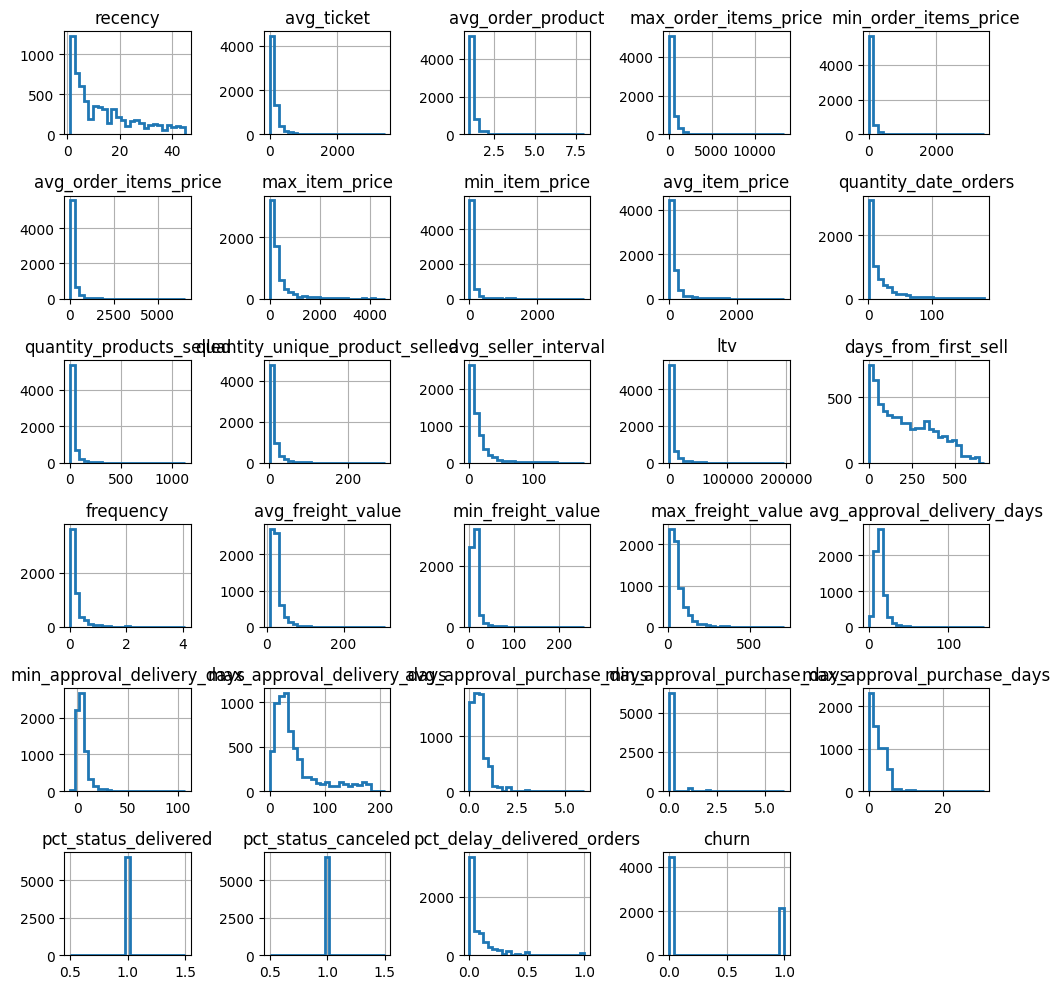

In [60]:
df1.hist(bins=25, figsize=(10, 10), histtype="step", linewidth=2);
plt.tight_layout()

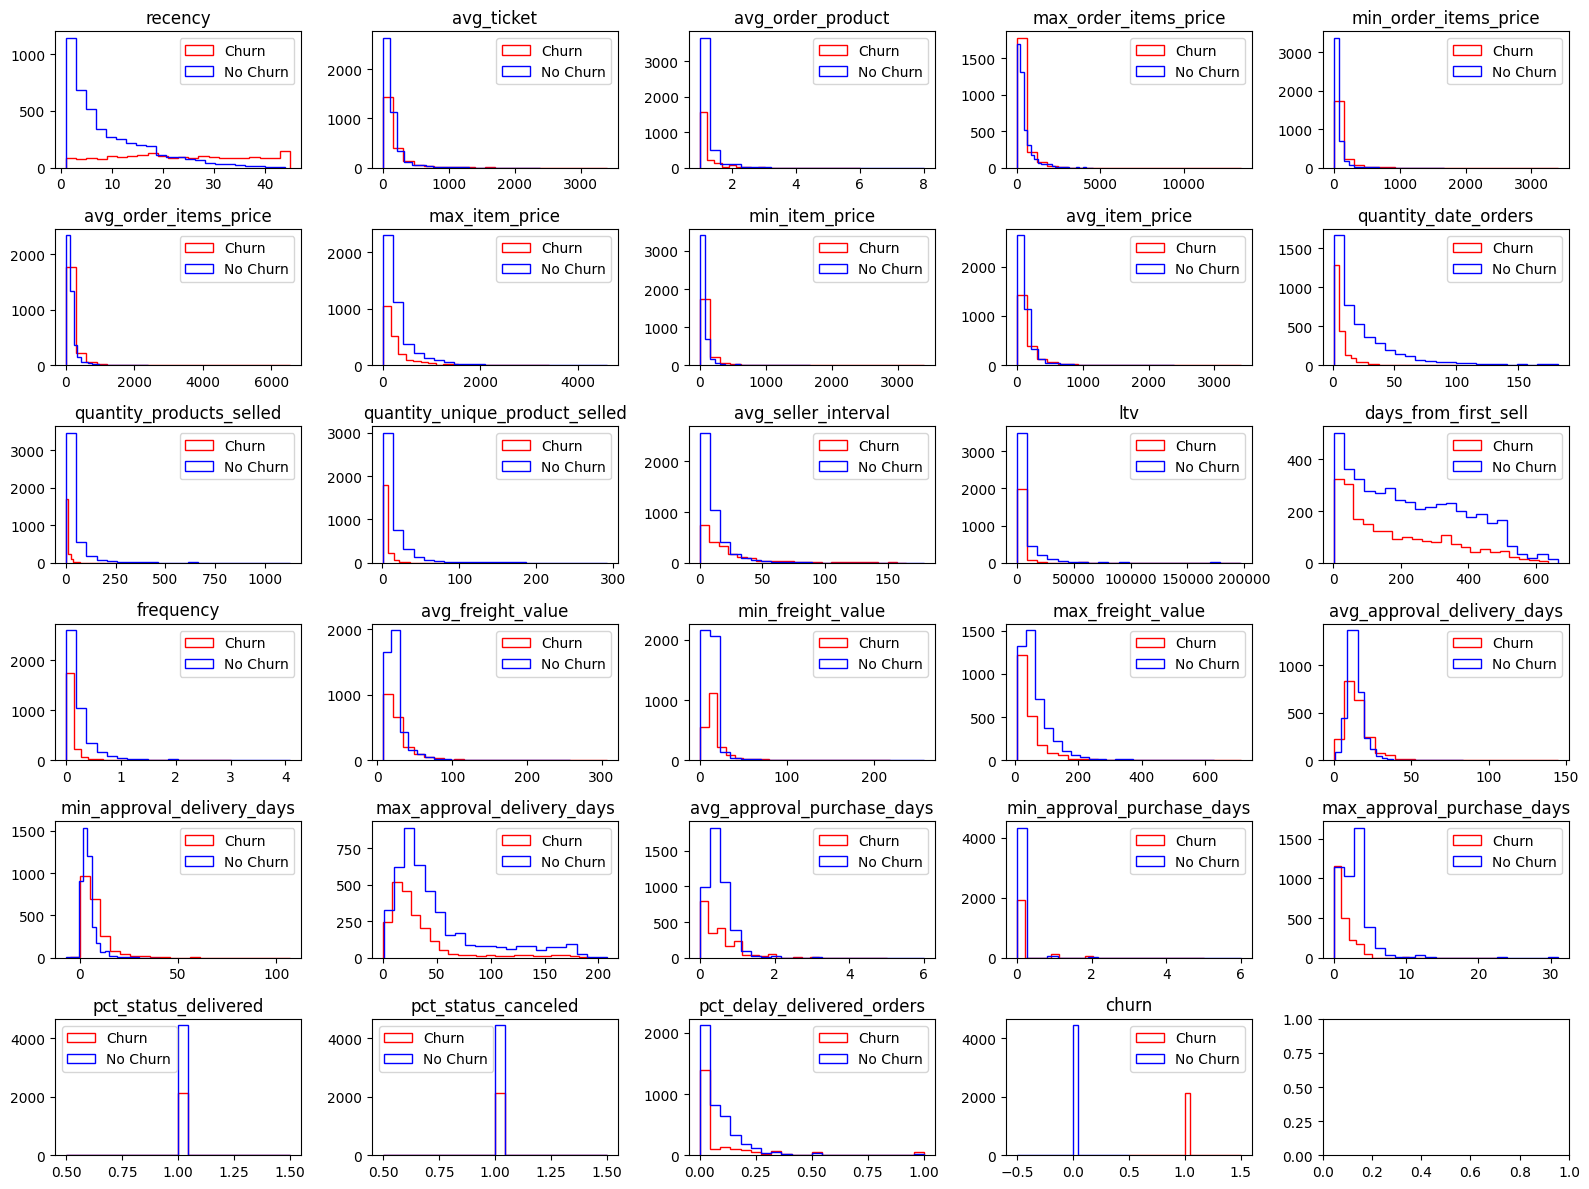

In [102]:
fig, ax = plt.subplots(6, 5, figsize=(16, 12))
ax = ax.flatten()

for axi, col in zip(ax, df1.columns):
    axi.hist(df1[mask][col], bins=22, color="r", histtype="step", label="Churn")
    axi.hist(df1[~mask][col], bins=22, color="b", histtype="step", label="No Churn")
    axi.set_title(col)
    axi.legend()

plt.tight_layout()

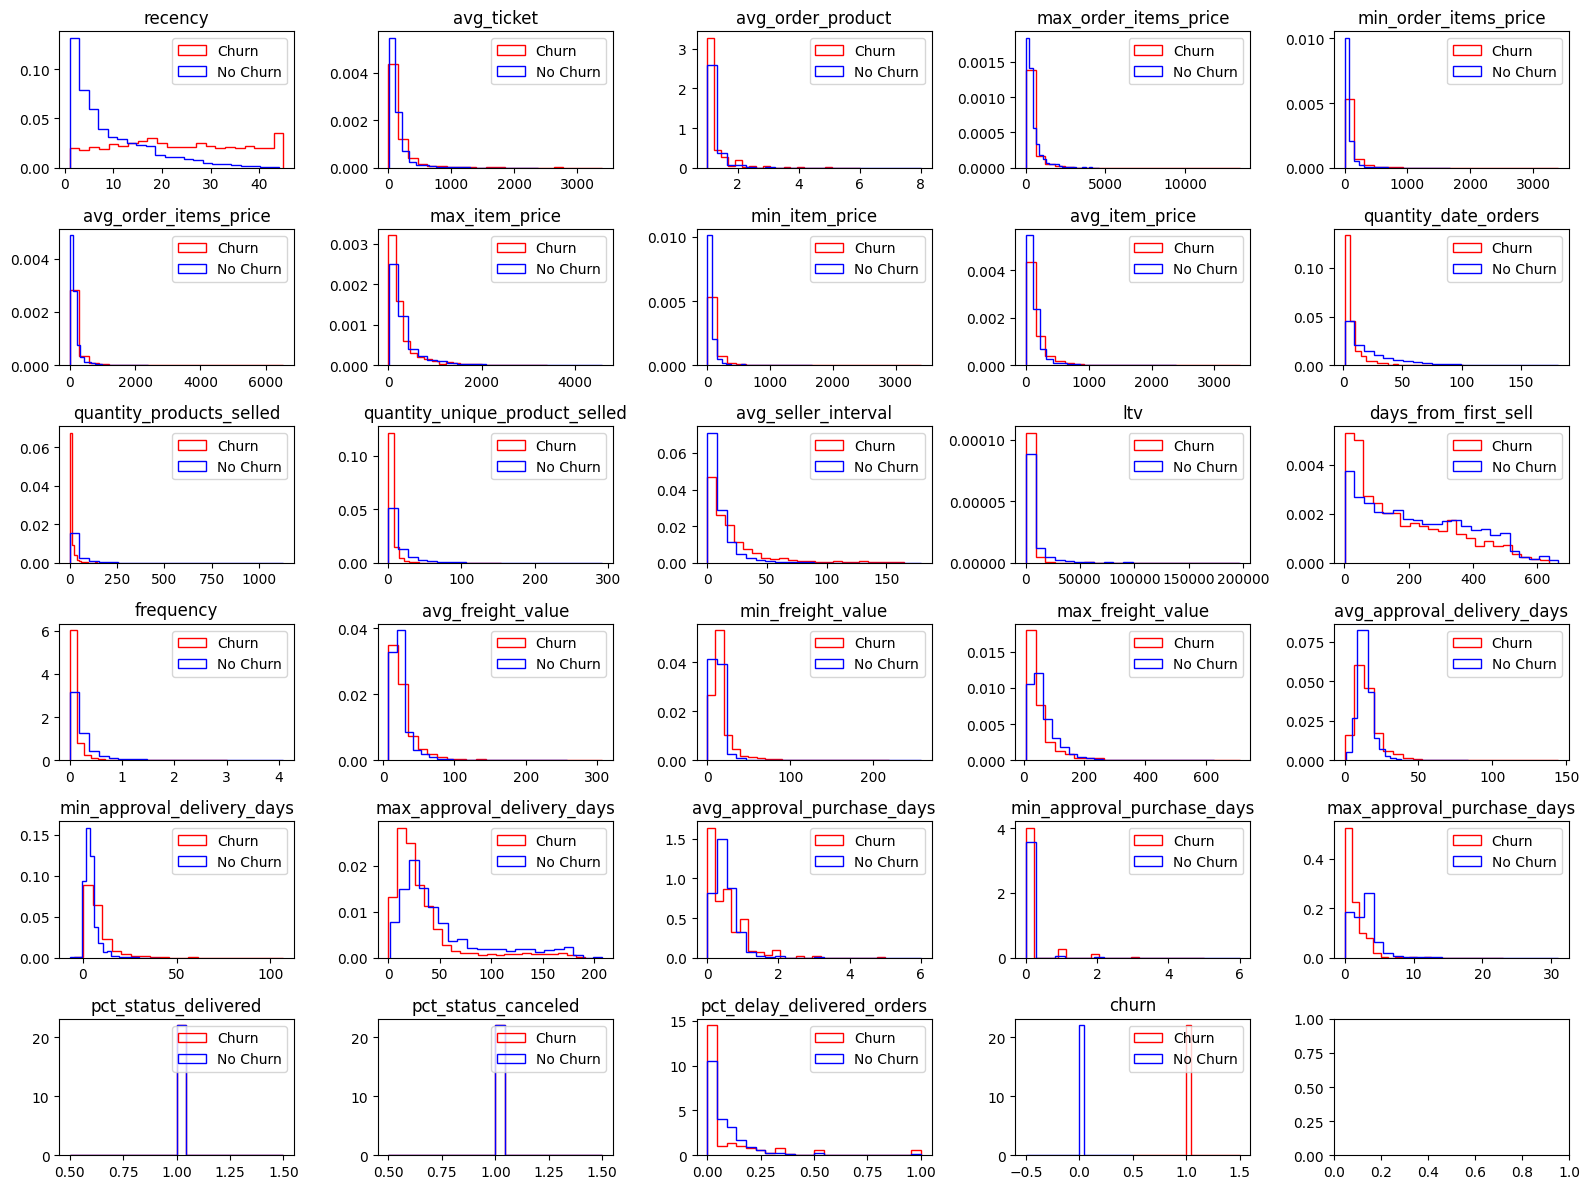

In [133]:
fig, ax = plt.subplots(6, 5, figsize=(16, 12))
ax = ax.flatten()

for axi, col in zip(ax, df1.columns):
    axi.hist(df1[mask][col], density=True, bins=22, color="r", histtype="step", label="Churn")
    axi.hist(df1[~mask][col], density=True, bins=22, color="b", histtype="step", label="No Churn")
    axi.set_title(col)
    axi.legend()

plt.tight_layout()

Checking history of the sellers.

In [85]:
print(f'Seller: {df.loc[df.ltv == df.ltv.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.ltv == df.ltv.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "avg_order_product", "quantity_date_orders"]
]

Seller: 4869f7a5dfa277a7dca6462dcf3b52b2


,_mt_date_reference,churn,ltv,days_from_first_sell,avg_ticket,quantity_unique_product_selled,avg_order_product,quantity_date_orders
2794,2018-01-01,0,91058.03,300,218.543410,30,1.039683,129
2795,2018-02-01,0,111012.23,331,227.922333,32,1.030952,144
2796,2018-03-01,0,129945.03,359,225.554968,38,1.028384,148
2797,2018-04-01,0,155490.93,390,232.974444,43,1.019881,156
2798,2018-05-01,0,176700.33,420,216.051215,49,1.024911,160
2799,2018-06-01,0,190727.93,451,202.695890,51,1.026362,156
2800,2018-07-01,0,206497.03,481,193.819967,57,1.025597,163
2801,2018-08-01,0,215043.23,512,180.066381,67,1.026408,158


In [98]:
print(f'Seller: {df.loc[df.avg_ticket == df.avg_ticket.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.avg_ticket == df.avg_ticket.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell",
     "avg_ticket", "quantity_products_selled", "quantity_date_orders", "avg_item_price",
     "max_freight_value", "max_approval_purchase_days", "max_approval_delivery_days"]
].T

Seller: 80ceebb4ee9b31afb6c6a916a574a1e2


,4972
_mt_date_reference,2018-08-01
churn,1
ltv,6729.0
days_from_first_sell,7
avg_ticket,6729.0
quantity_products_selled,1
quantity_date_orders,1
avg_item_price,6729.0
max_freight_value,193.21
max_approval_purchase_days,2


In [93]:
print(f'Seller: {df.loc[df.avg_approval_delivery_days == df.avg_approval_delivery_days.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.avg_approval_delivery_days == df.avg_approval_delivery_days.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "quantity_date_orders", "max_approval_purchase_days", "avg_approval_delivery_days",
     "max_approval_delivery_days", "min_approval_delivery_days"]
].T

Seller: 4342d4b2ba6b161468c63a7e7cfce593


,2655,2656,2657,2658,2659
_mt_date_reference,2018-01-01,2018-02-01,2018-06-01,2018-07-01,2018-08-01
churn,0,1,1,1,1
ltv,1039.2,2338.2,2468.1,2468.1,2867.1
days_from_first_sell,9,40,160,190,221
avg_ticket,129.9,129.9,129.9,129.9,264.45
quantity_unique_product_selled,1,1,2,2,2
quantity_date_orders,4,7,8,4,2
max_approval_purchase_days,1,4,4,4,1
avg_approval_delivery_days,5.75,31.388889,144.631579,163.090909,15.0
max_approval_delivery_days,9,40,160,181,23


In [94]:
print(f'Seller: {df.loc[df.max_approval_delivery_days == df.max_approval_delivery_days.max(), "seller_id"].values[0]}')
df.loc[
    df.seller_id == df.loc[df.max_approval_delivery_days == df.max_approval_delivery_days.max(), "seller_id"].values[0],
    ["_mt_date_reference", "churn", "ltv", "days_from_first_sell", "avg_ticket",
     "quantity_unique_product_selled", "quantity_date_orders", "max_approval_purchase_days", "avg_approval_delivery_days",
     "max_approval_delivery_days", "min_approval_delivery_days"]
].T

Seller: 7a67c85e85bb2ce8582c35f2203ad736


,4723,4724,4725,4726,4727,4728,4729,4730
_mt_date_reference,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
churn,0,0,0,0,0,0,0,0
ltv,97311.03,106160.38,116556.57,123569.8,129833.67,135173.16,137632.94,140092.71
days_from_first_sell,339,370,398,429,459,490,520,551
avg_ticket,122.847338,125.203357,131.549107,131.54206,130.678482,125.68752,123.44345,120.179426
quantity_unique_product_selled,97,95,88,87,93,88,86,79
quantity_date_orders,161,162,161,162,161,157,150,138
max_approval_purchase_days,4,5,5,5,5,5,5,5
avg_approval_delivery_days,9.897912,10.123426,12.200521,13.503896,13.885246,14.178977,14.275229,15.505263
max_approval_delivery_days,86,117,208,208,208,208,208,208
